In [1]:
!pip install gpxpy

     |████████████████████████████████| 112kB 2.8MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.4.0-cp36-none-any.whl size=42812 sha256=fa36c052868aa975fdba9f5031e1c877d06fc14c844da040375c057b9a53f000
  Stored in directory: /root/.cache/pip/wheels/77/d7/ee/cb4d7a151ce924c35e681377fb90a0b882f55bfd3c2c586739
Successfully built gpxpy


In [0]:
import dask.dataframe as dd
import pandas as pd#pandas to create small dataframes 
import folium
import datetime
import time
import numpy as np
import matplotlib
from tqdm import  tqdm_notebook as tqdm 
from matplotlib import rcParams
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb
# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 
import matplotlib.pylab as plt

In [3]:
cd /content/drive/My Drive/NYC TAXI

/content/drive/My Drive/NYC TAXI


In [0]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb 

month = dd.read_csv('/content/drive/My Drive/NYC TAXI/2018_jan.csv')

In [5]:
month.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULlongitude,PULlatitude,DOLlongitude,DOLlatitude
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,-73.950709,40.804176,-73.965522,40.801916
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,-73.978732,40.784025,-73.954728,40.765305
2,2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,-73.945142,40.776681,-73.959634,40.766952
3,3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,-73.954728,40.765305,-73.979636,40.653477
4,4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,-74.003811,40.752412,-73.978732,40.784025


**Data Cleaning**

In [0]:
month= month.dropna() 

**Pickup Latitude and Pickup Longitude**

In [0]:
# Plotting pickup cordinates which are outside the bounding box of New-York 

# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.PULlongitude <= -74.15) | (month.PULlatitude <= 40.5774)| \
                   (month.PULlongitude >= -73.7004) | (month.PULlatitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['PULlatitude']) != 0:
        folium.Marker(list((j['PULlatitude'],j['PULlongitude']))).add_to(map_osm)

**Dropoff Latitude & Dropoff Longitude**

In [0]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations

outlier_locations = month[((month.DOLlongitude <= -74.15) | (month.DOLlatitude <= 40.5774)| \
                   (month.DOLlongitude >= -73.7004) | (month.DOLlatitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['PULlatitude']) != 0:
        folium.Marker(list((j['DOLlatitude'],j['DOLlongitude']))).add_to(map_osm)

**Trip Durations:**

In [0]:
def convert_to_unix(s): 
  return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [0]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time

    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values] 
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULlongitude','PULlatitude','DOLlongitude','DOLlatitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup

    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

In [0]:
frame_with_durations = return_with_trip_times(month)

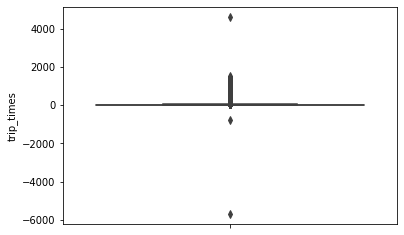

In [12]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [13]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -5711.583333333333
10 percentile value is 3.9
20 percentile value is 5.5
30 percentile value is 7.0
40 percentile value is 8.6
50 percentile value is 10.366666666666667
60 percentile value is 12.45
70 percentile value is 15.116666666666667
80 percentile value is 18.9
90 percentile value is 25.6
100 percentile value is  4615.066666666667


In [14]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.6
91 percentile value is 26.65
92 percentile value is 27.85
93 percentile value is 29.25
94 percentile value is 30.9
95 percentile value is 32.88333333333333
96 percentile value is 35.416666666666664
97 percentile value is 38.88333333333333
98 percentile value is 44.166666666666664
99 percentile value is 54.166666666666664
100 percentile value is  4615.066666666667


In [0]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

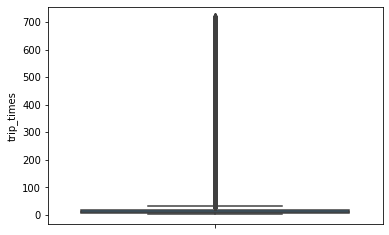

In [16]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

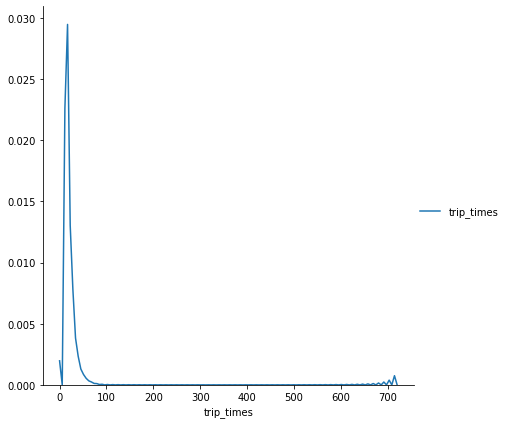

In [17]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [0]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

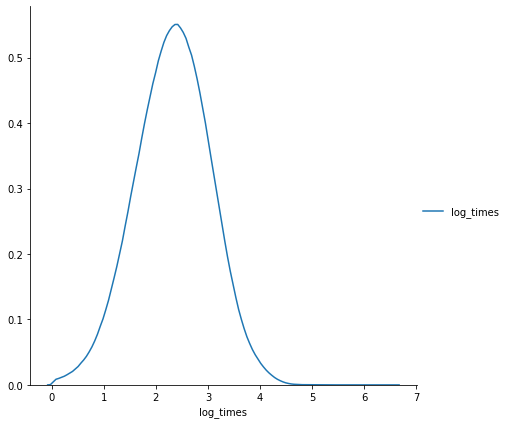

In [19]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

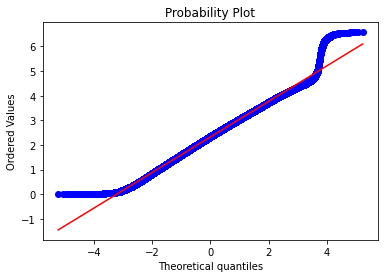

In [20]:
import scipy 
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

**Speed**

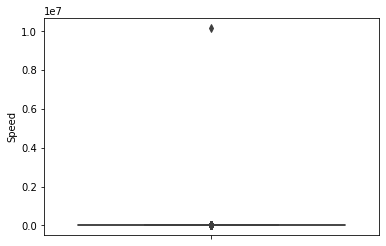

In [21]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [22]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.764192139737992
20 percentile value is 7.02111801242236
30 percentile value is 8.03483941208492
40 percentile value is 9.0
50 percentile value is 10.014705882352942
60 percentile value is 11.170662905500706
70 percentile value is 12.625
80 percentile value is 14.746987951807231
90 percentile value is 18.94736842105263
100 percentile value is  10181221.253731342


In [23]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 18.94736842105263
91 percentile value is 19.655172413793103
92 percentile value is 20.47244094488189
93 percentile value is 21.41643059490085
94 percentile value is 22.513989637305702
95 percentile value is 23.80865603644647
96 percentile value is 25.37334263782275
97 percentile value is 27.341772151898734
98 percentile value is 30.049586776859503
99 percentile value is 34.154852780806976
100 percentile value is  10181221.253731342


In [24]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 34.154852780806976
99.1 percentile value is 34.71943887775551
99.2 percentile value is 35.32314923619272
99.3 percentile value is 36.0
99.4 percentile value is 36.7506132461161
99.5 percentile value is 37.59332905708788
99.6 percentile value is 38.57389635316699
99.7 percentile value is 39.756177924217454
99.8 percentile value is 41.278731836195504
99.9 percentile value is 43.62944162436549
100 percentile value is  10181221.253731342


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [26]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.443704729144551

**Trip Distance**

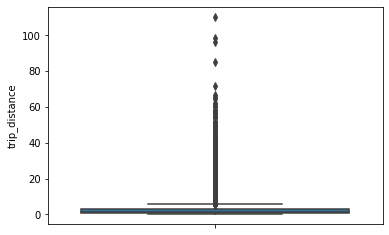

In [27]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [28]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.82
30 percentile value is 1.03
40 percentile value is 1.3
50 percentile value is 1.56
60 percentile value is 1.9
70 percentile value is 2.46
80 percentile value is 3.4
90 percentile value is 6.24
100 percentile value is  110.29


In [29]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.24
91 percentile value is 6.87
92 percentile value is 7.6
93 percentile value is 8.5
94 percentile value is 9.32
95 percentile value is 10.2
96 percentile value is 11.3
97 percentile value is 13.21
98 percentile value is 16.9
99 percentile value is 18.56
100 percentile value is  110.29


In [30]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.56
99.1 percentile value is 18.79
99.2 percentile value is 19.01
99.3 percentile value is 19.3
99.4 percentile value is 19.63
99.5 percentile value is 20.03
99.6 percentile value is 20.5
99.7 percentile value is 21.0
99.8 percentile value is 21.7
99.9 percentile value is 23.19
100 percentile value is  110.29


In [0]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<25)] 

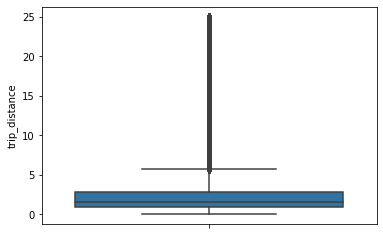

In [32]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

**Total Fare**

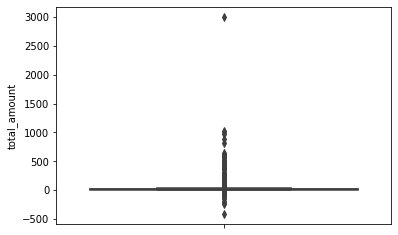

In [33]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [34]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.36
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.96
50 percentile value is 11.3
60 percentile value is 12.95
70 percentile value is 15.3
80 percentile value is 18.59
90 percentile value is 27.36
100 percentile value is  3006.8


In [35]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.36
91 percentile value is 29.3
92 percentile value is 31.8
93 percentile value is 35.16
94 percentile value is 38.76
95 percentile value is 42.62
96 percentile value is 46.92
97 percentile value is 52.8
98 percentile value is 60.06
99 percentile value is 70.26
100 percentile value is  3006.8


In [36]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 70.27
99.5 percentile value is 73.16
99.6 percentile value is 73.2
99.7 percentile value is 75.67
99.8 percentile value is 78.82
99.9 percentile value is 90.96
100 percentile value is  3006.8


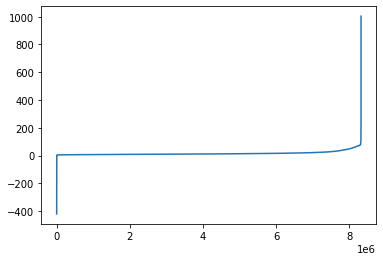

In [37]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

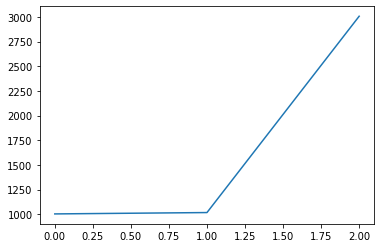

In [38]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

**Remove all outliers/erronous points.**

In [0]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):
  new_frame = new_frame[((new_frame.DOLlongitude >= -74.15) & (new_frame.DOLlongitude <= -73.7004) &\
                       (new_frame.DOLlatitude >= 40.5774) & (new_frame.DOLlatitude <= 40.9176)) & \
                       ((new_frame.PULlongitude >= -74.15) & (new_frame.PULlatitude >= 40.5774)& \
                       (new_frame.PULlongitude <= -73.7004) & (new_frame.PULlatitude <= 40.9176))]
  new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
  new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25)]
  new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
  new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
  return new_frame

In [40]:
print ("Removing outliers in the month of Jan-2018")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2018
----
fraction of data points that remain after removing outliers 0.9897020121882647


**Clustering/Segmentation**

In [41]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['PULlatitude', 'PULlongitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['PULlatitude', 'PULlongitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(20,40,1):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)       

On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6059789808152064 
---
On choosing a cluster size of  21 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.5509853195795859 
---
On choosing a cluster size of  22 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.47803123670056197 
---
On choosing a cluster size of  23 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 17.0 
Min inter-cluster distanc

**Inference:**

The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 20

In [0]:
# Getting 24 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=24, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['PULlatitude', 'PULlongitude']])

In [0]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)

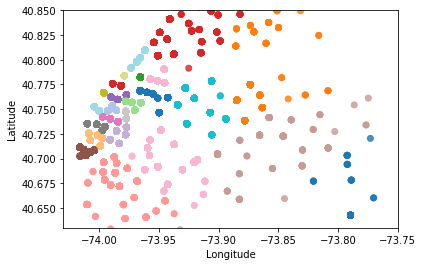

In [44]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.PULlongitude.values[:100000], frame.PULlatitude.values[:100000],
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.8)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

**Time-binning**

In [0]:
#Refer:https://www.unixtimestamp.com/
# 1514764800 : 2018-01-01 00:00:00 
# 1517443200 : 2018-02-01 00:00:00 
# 1519862400 : 2018-03-01 00:00:00

# 1546300800 : 2019-01-01 00:00:00 
# 1548979200 : 2019-02-01 00:00:00 
# 1551398400 : 2016-03-01 00:00:00


def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1514764800,1517443200,1519862400],\
                    [1546300800,1548979200,1551398400]]
    
    start_pickup_unix=unix_times[year-2018][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame 

In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['PULlatitude', 'PULlongitude']])
jan_2018_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2018)
jan_2018_groupby = jan_2018_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [47]:
jan_2018_frame.head()

,passenger_count,trip_distance,PULlongitude,PULlatitude,DOLlongitude,DOLlatitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,0.5,-73.950709,40.804176,-73.965522,40.801916,5.80,3.300000,1.514766e+09,9.090909,8,35
1,1,2.7,-73.978732,40.784025,-73.954728,40.765305,15.30,18.166667,1.514767e+09,8.917431,20,37
2,2,0.8,-73.945142,40.776681,-73.959634,40.766952,8.30,5.916667,1.514765e+09,8.112676,15,33
3,1,10.2,-73.954728,40.765305,-73.979636,40.653477,34.80,32.483333,1.514766e+09,18.840431,0,35
4,2,2.5,-74.003811,40.752412,-73.978732,40.784025,16.55,17.800000,1.514765e+09,8.426966,23,33


In [0]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['PULlatitude', 'PULlongitude']])
    

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

In [0]:
jan_2019 = dd.read_csv('/content/drive/My Drive/NYC TAXI/2019_jan.csv') 
feb_2019 = dd.read_csv('/content/drive/My Drive/NYC TAXI/2019_feb.csv') 
mar_2019 = dd.read_csv('/content/drive/My Drive/NYC TAXI/2019_mar.csv') 

In [0]:
jan_2019=jan_2019.dropna()
feb_2019=feb_2019.dropna()
mar_2019=mar_2019.dropna()

In [51]:
jan_2019_frame,jan_2019_groupby = datapreparation(jan_2019,kmeans,1,2019)
feb_2019_frame,feb_2019_groupby = datapreparation(feb_2019,kmeans,2,2019)
mar_2019_frame,mar_2019_groupby = datapreparation(mar_2019,kmeans,3,2019) 

Return with trip times..
Remove outliers..
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Estimating clusters..
Final groupbying..


**Smoothing**

In [0]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,24):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values 

In [0]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened
jan_2018_unique = return_unq_pickup_bins(jan_2018_frame)
jan_2019_unique = return_unq_pickup_bins(jan_2019_frame)
# for every month we get all indices of 10min intravels in which atleast one pickup got happened
#feb
feb_2019_unique = return_unq_pickup_bins(feb_2019_frame)

#march
mar_2019_unique = return_unq_pickup_bins(mar_2019_frame)

In [54]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(24):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2018_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  72
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  151
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  72
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  167
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  73
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  72
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  77
----------

In [0]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,24):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [0]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,24):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [0]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2018_fill = fill_missing(jan_2018_groupby['trip_distance'].values,jan_2018_unique)

#Smoothing Missing values of Jan-2015
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values,jan_2018_unique)

In [58]:
print("number of 10min intravels among all the clusters ",len(jan_2018_fill))

number of 10min intravels among all the clusters  107136


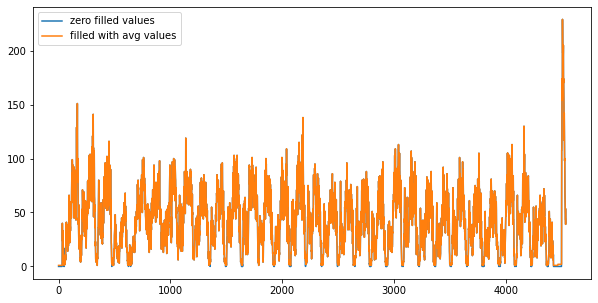

In [59]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2018_fill[4464:9000], label="zero filled values")
plt.plot(jan_2018_smooth[4464:9000], label="filled with avg values")
plt.legend()
plt.show()

In [0]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values,jan_2018_unique)
jan_2019_smooth = fill_missing(jan_2019_groupby['trip_distance'].values,jan_2019_unique)
feb_2019_smooth = fill_missing(feb_2019_groupby['trip_distance'].values,feb_2019_unique)
mar_2019_smooth = fill_missing(mar_2019_groupby['trip_distance'].values,mar_2019_unique)

# number of 10min indices for jan 201= 24*31*60/10 = 4464
# number of 10min indices for jan 2019 = 24*31*60/10 = 4464
# number of 10min indices for feb 2019 = 24*28*60/10 = 4032
# number of 10min indices for march 2019 = 24*31*60/10 = 4464
# regions_cum: it will contain 20 lists, each list will contain 4464+4032+4464 values which represents the number of pickups 
# that are happened for three months in 2019 data

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []
for i in range(0,24):
    regions_cum.append(jan_2019_smooth[4464*i:4464*(i+1)]+feb_2019_smooth[4032*i:4032*(i+1)]+mar_2019_smooth[4464*i:4464*(i+1)]) 

**Time series and Fourier Transforms**

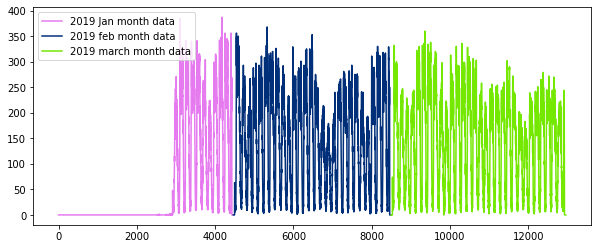

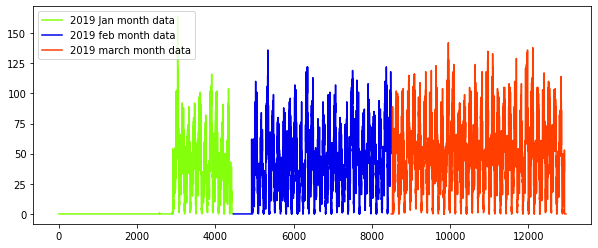

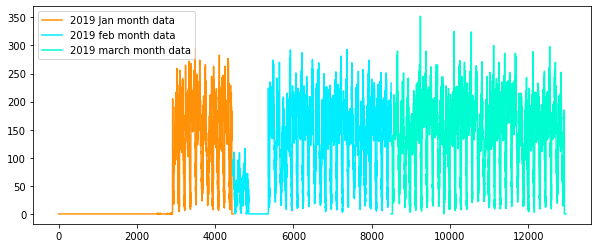

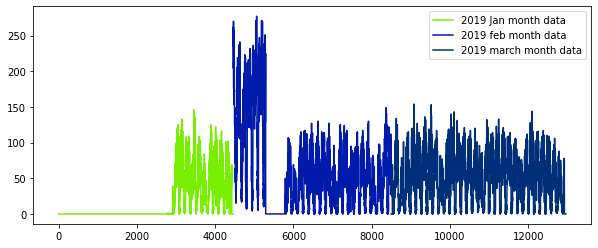

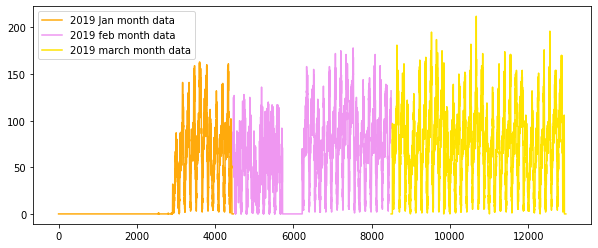

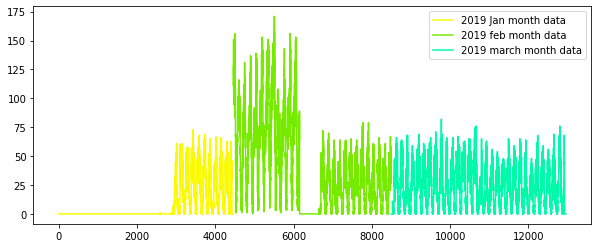

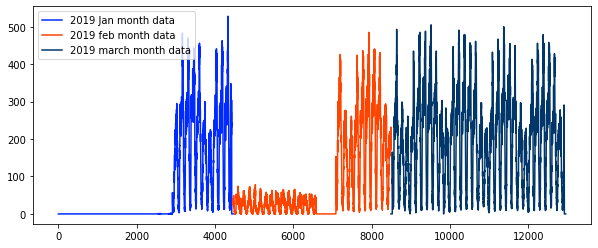

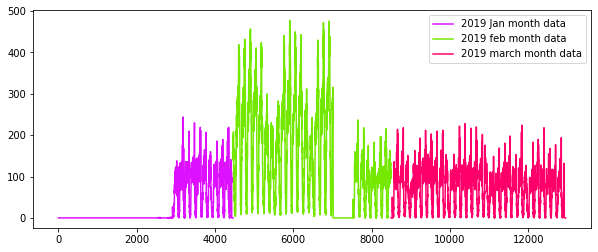

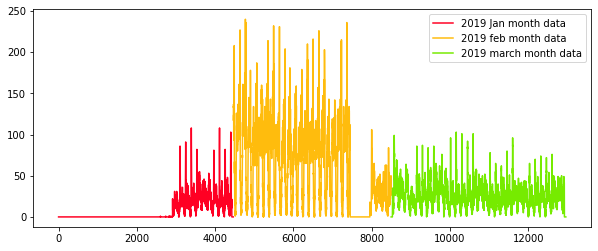

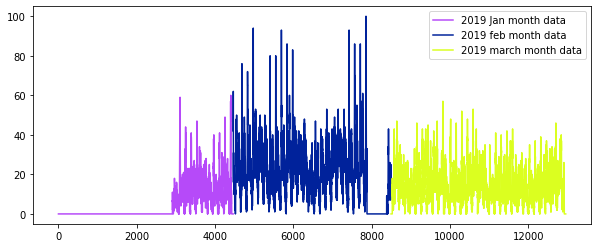

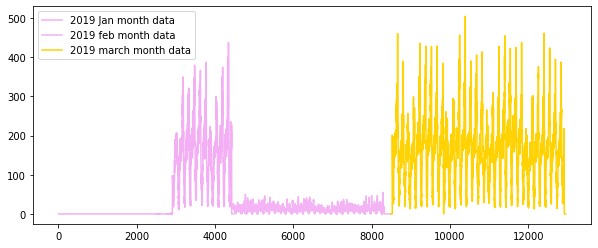

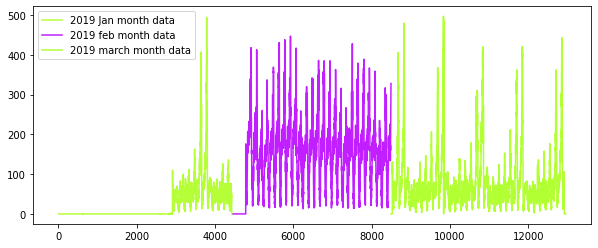

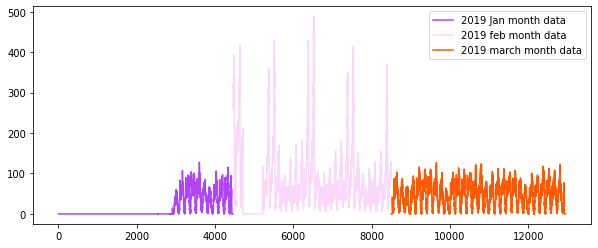

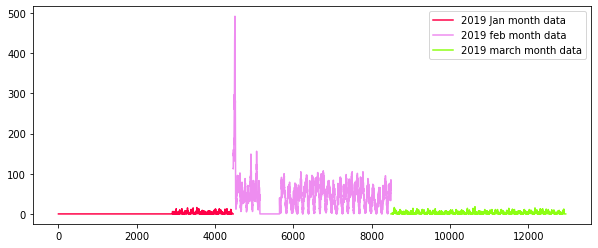

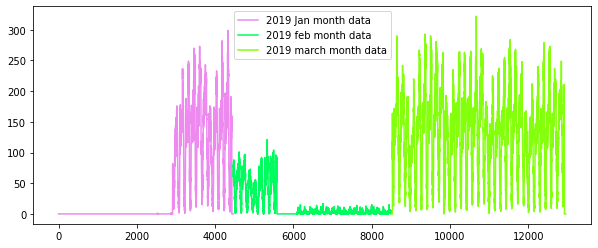

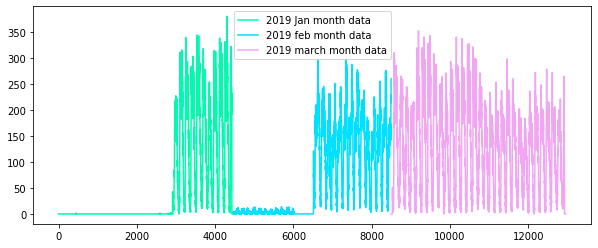

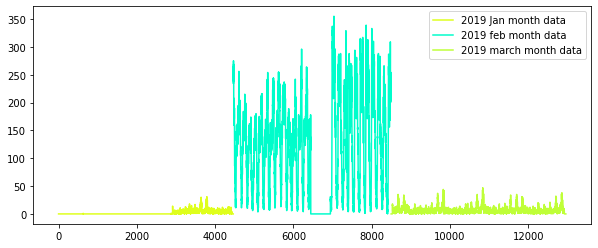

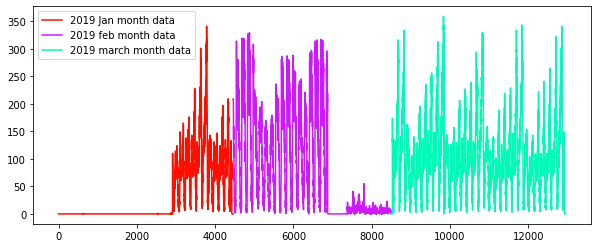

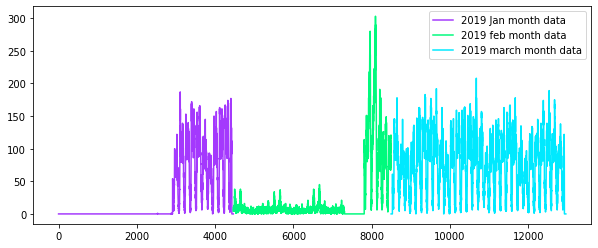

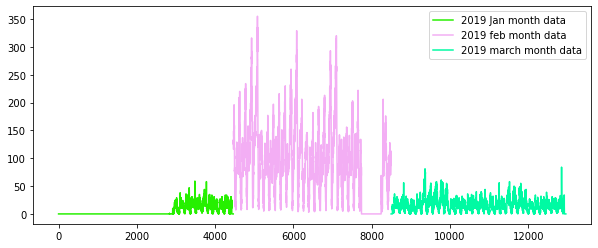

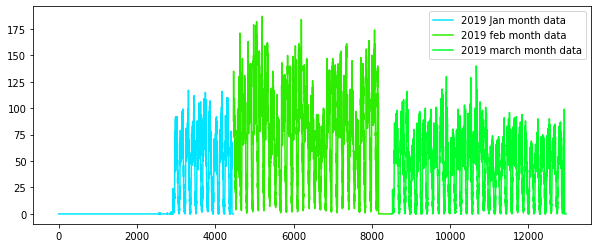

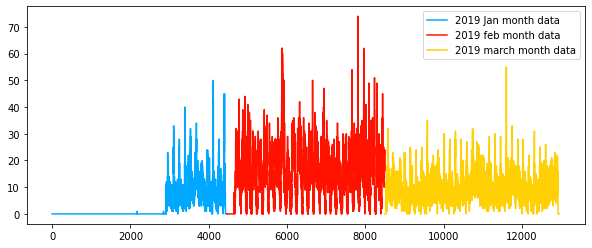

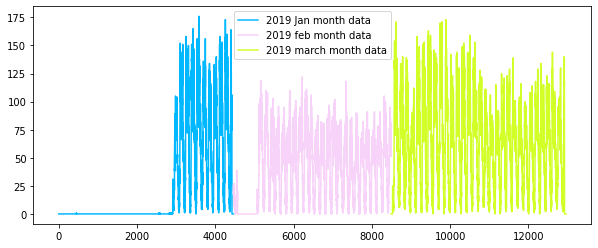

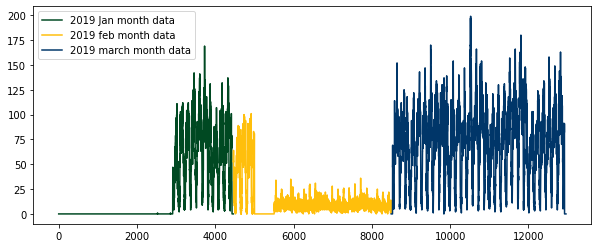

In [61]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8496))
third_x = list(range(8496,12960))
for i in range(24):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2019 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8496], color=uniqueish_color(), label='2019 feb month data')
    plt.plot(third_x,regions_cum[i][8496:12960], color=uniqueish_color(), label='2019 march month data')
    plt.legend()
    plt.show()

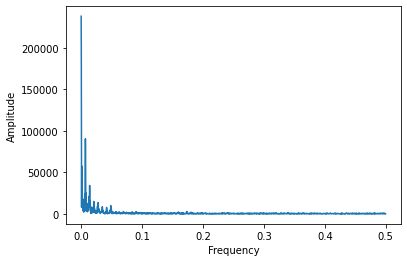

In [62]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2019_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [0]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2018_smooth
ratios_jan['Prediction']=jan_2019_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

**Modelling: Baseline Models**

**Simple Moving Averages**

- **Using Ratios**

In [0]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*24):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)            
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

- **Using Previous known values**

In [0]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*24):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Weighted Moving Averages**

**Using Ratios**

In [0]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*24):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Using Previous known values**

In [0]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*24):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Exponential Weighted Moving Averages**

**Using Ratios**

In [0]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*24):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Using Previous known values**

In [0]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*24):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [0]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

**Comparison between baseline models**


In [71]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2019 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2019 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2019 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1666297683485303       MSE:  124.73722184886499
Moving Averages (2019 Values) -                        MAPE:  0.13692668825647328        MSE:  75.30333408004779
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.16337149503932144       MSE:  118.30986783154121
Weighted Moving Averages (2019 Values) -               MAPE:  0.13092658607651536       MSE:  70.81711096176822
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.1616704759724621       MSE:  114.26541031959378
Exponential Moving Averages (2019 Values) -         MAPE:  0.1310331225

**Regression Models**

- **Train-Test Split**

In [0]:

# number of 10min indices for jan 2019 = 24*31*60/10 = 4464
# number of 10min indices for feb 2019 = 24*28*60/10 = 4032
# number of 10min indices for march 2019 = 24*31*60/10 = 4464
# regions_cum: it will contain 20 lists, each list will contain 4464+4032+4464 values which represents the number of pickups 
# that are happened for three months in 2019 data

number_of_time_stamps = 5

output = []

tsne_lat = []

tsne_lon = []

tsne_weekday = []

tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,24):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*12955)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*12955)

    # jan 1st 2019 is tuesday, so we start our day from 2: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+2)%7) for k in range(5,4464+4032+4464)])
  

    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))

    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [73]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 24*12955 == len(output)*len(output[0])

True

In [0]:
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat

predict_list = []
tsne_flat_exp_avg = []
for r in range(0,24):
    for i in range(0,12960):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[] 

**Holts Winter Triple exponential smoothing**

In [0]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha = 0.2
beta = 0.15
gamma = 0.2
season_len = 24

predict_values_2 =[]
predict_list_2 = []
tsne_flat_exp_avg_2 = []
for r in range(0,24):
    predict_values_2 = triple_exponential_smoothing(regions_cum[r][0:12960], season_len, alpha, beta, gamma, 0)
    predict_list_2.append(predict_values_2[5:])

**Amplitude and Frequencies**

In [0]:
amplitude = []
frequency = []
for i in range(24):
    amp  = np.abs(np.fft.fft(regions_cum[i][0:12960]))#amplitude calculation
    freq = np.abs(np.fft.fftfreq(12960, 1)) #frequencies calculation
    amp_indices = np.argsort(-amp)[1:]    #sorting amplitude 
    amp_values = []
    freq_values = []
    for j in range(0, 9, 2):   #taking top 5 amplitudes and frequencies
        amp_values.append(amp[amp_indices[j]])
        freq_values.append(freq[amp_indices[j]])
    for k in range(13104):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude.append(amp_values)
        frequency.append(freq_values)

In [0]:
#for train and test data fourier frequencies 
train_frequencies = [frequency[i*12955:(12955*i+9068)] for i in range(0,24)]
test_frequencies = [frequency[(12955*(i))+9068:12955*(i+1)] for i in range(0,24)]

In [0]:
train_amplitude = [amplitude[i*12955:(12955*i+9068)] for i in range(0,24)]
test_amplitude = [amplitude[(12955*(i))+9068:12955*(i+1)] for i in range(0,24)] 

In [0]:
# extracting first 9068 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*12955:(12955*i+9068)] for i in range(0,24)]
# temp = [0]*(12955 - 9068) 
test_features = [tsne_feature[(12955*(i))+9068:12955*(i+1)] for i in range(0,24)] 

In [79]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2019 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(12955*0.7))
print("size of test data :", int(12955*0.3))

size of train data : 9068
size of test data : 3886


In [85]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 24 Number of data points in trian data 9068 Each data point contains 5 features
Number of data clusters 24 Number of data points in test data 3887 Each data point contains 5 features


In [0]:
# extracting first 9169 timestamp values i.e 70% of 12955 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9068] for i in tsne_lat]
tsne_train_flat_lon = [i[:9068] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9068] for i in tsne_weekday]
tsne_train_flat_output = [i[:9068] for i in output]
tsne_train_flat_exp_avg = [i[:9068] for i in predict_list] 
tsne_train_flat_triple_avg = [i[:9068] for i in predict_list_2]

In [0]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9068:] for i in tsne_lat]
tsne_test_flat_lon = [i[9068:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9068:] for i in tsne_weekday]
tsne_test_flat_output = [i[9068:] for i in output]
tsne_test_flat_exp_avg = [i[9068:] for i in predict_list] 
tsne_test_flat_triple_avg = [i[9068:] for i in predict_list_2] 

In [0]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,24):
    train_new_features.extend(train_features[i])

test_new_features = []
for i in range(0,24):
    test_new_features.extend(test_features[i])


train_freq=[]
test_freq=[]
train_amp=[]
test_amp=[] 
for i in range(0,24):
  train_freq.extend(train_frequencies[i])
  test_freq.extend(test_frequencies[i])
  train_amp.extend(train_amplitude[i])
  test_amp.extend(test_amplitude[i])

In [0]:
#stacking new features,frequencies and amplitudes horizontally using hstack.
train_brand_new_features=np.hstack((train_new_features,train_freq,train_amp))
test_brand_new_features=np.hstack((test_new_features,test_freq,test_amp)) 

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[]) 
tsne_train_triple_avg = sum(tsne_train_flat_triple_avg,[])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])
tsne_test_triple_avg = sum(tsne_test_flat_triple_avg,[])

In [99]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1','freq1','freq2','freq3','freq4','freq5','Amp1','Amp2','Amp3','Amp4','Amp']
df_train = pd.DataFrame(data=train_brand_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg 
df_train['3EXP'] = tsne_train_triple_avg
print(df_train.shape)

(217632, 20)


In [100]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_brand_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
df_test['3EXP'] = tsne_test_triple_avg
print(df_test.shape) 

(93288, 20)


In [101]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp,lat,lon,weekday,exp_avg,3EXP
0,226.0,213.0,222.0,232.0,227.0,0.006944,0.000077,0.000154,0.013889,0.006867,538775.619149,388760.143563,319284.805585,180939.797805,161059.373271,40.767198,-73.961307,2,227,223.391485
1,213.0,222.0,232.0,227.0,223.0,0.006944,0.000077,0.000154,0.013889,0.006867,538775.619149,388760.143563,319284.805585,180939.797805,161059.373271,40.767198,-73.961307,2,224,234.569946
2,222.0,232.0,227.0,223.0,244.0,0.006944,0.000077,0.000154,0.013889,0.006867,538775.619149,388760.143563,319284.805585,180939.797805,161059.373271,40.767198,-73.961307,2,238,233.640274
3,232.0,227.0,223.0,244.0,243.0,0.006944,0.000077,0.000154,0.013889,0.006867,538775.619149,388760.143563,319284.805585,180939.797805,161059.373271,40.767198,-73.961307,2,241,230.558181
4,227.0,223.0,244.0,243.0,216.0,0.006944,0.000077,0.000154,0.013889,0.006867,538775.619149,388760.143563,319284.805585,180939.797805,161059.373271,40.767198,-73.961307,2,223,223.694005


**Linear Regression**

In [102]:
#hyperparameter tuning using GridSearch
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
model=SGDRegressor(loss='squared_loss')
alpha=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
param_grid={"alpha":alpha} 
clf = GridSearchCV(model,param_grid, scoring = "neg_mean_absolute_error", cv=10)
clf.fit(df_train,tsne_train_output) 
clf.best_params_ 

{'alpha': 0.001}

In [103]:
#applying linear regression with alpha=1
model = SGDRegressor(loss = "squared_loss", alpha =0.001)
model.fit(df_train, tsne_train_output)
pred_tr = model.predict(df_train)
pred_test = model.predict(df_test)

train_MAPE_lr = mean_absolute_error(tsne_train_output, pred_tr)/ (sum(tsne_train_output)/len(tsne_train_output))
train_MSE_lr = mean_squared_error(tsne_train_output, pred_tr)

test_MAPE_lr = mean_absolute_error(tsne_test_output, pred_test)/ (sum(tsne_test_output)/len(tsne_test_output))
test_MSE_lr = mean_squared_error(tsne_test_output, pred_test)

print('Mean absolute percentage train error for linear regression =',train_MAPE_lr)
print('Mean absolute percentage test error for linear regression =',test_MAPE_lr)
print('-'*50)
print('Mean Squared train error for linear regression =',train_MSE_lr)
print('Mean Squared test error for linear regression =',test_MSE_lr)

Mean absolute percentage train error for linear regression = 1.340515078920607e+17
Mean absolute percentage test error for linear regression = 8.218309977766232e+16
--------------------------------------------------
Mean Squared train error for linear regression = 4.897437226020706e+37
Mean Squared test error for linear regression = 4.848010708662273e+37


**Random Forest Regressor**

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":[10,20,50,100,150,200,250,300],
              "max_depth": [2,5,10,20,50,100,200,250],
              "min_samples_split": sp_randint(120,190),
              "min_samples_leaf": sp_randint(25,65)
             }

clf = RandomForestRegressor(random_state=25,n_jobs=-1)

model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='neg_mean_absolute_error',random_state=25)
model.fit(df_train,tsne_train_output)
model.best_estimator_ 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=33,
                      min_samples_split=148, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=False,
                      random_state=25, verbose=0, warm_start=False)

In [105]:
model=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=33, min_samples_split=148,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=25, verbose=0, warm_start=False)
model.fit(df_train,tsne_train_output)
pred_tr = model.predict(df_train)
pred_test = model.predict(df_test)

train_MAPE_rf = mean_absolute_error(tsne_train_output, pred_tr)/ (sum(tsne_train_output)/len(tsne_train_output))
train_MSE_rf = mean_squared_error(tsne_train_output, pred_tr)

test_MAPE_rf = mean_absolute_error(tsne_test_output, pred_test)/ (sum(tsne_test_output)/len(tsne_test_output))
test_MSE_rf = mean_squared_error(tsne_test_output, pred_test)

print('Mean absolute percentage train error for Random Forest Regressor =',train_MAPE_rf)
print('Mean absolute percentage test error for Random Forest Regressor =',test_MAPE_rf)
print('-'*50)
print('Mean Squared train error for Random Forest Regressor =',train_MSE_rf)
print('Mean Squared test error for Random Forest Regressor=',test_MSE_rf)

Mean absolute percentage train error for Random Forest Regressor = 0.09337470610233024
Mean absolute percentage test error for Random Forest Regressor = 0.09618676851774526
--------------------------------------------------
Mean Squared train error for Random Forest Regressor = 65.31068793386667
Mean Squared test error for Random Forest Regressor= 117.26364637337214


In [106]:

#feature importances based on analysis using random forest
print (df_train.columns)
print (model.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'freq1', 'freq2', 'freq3',
       'freq4', 'freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp', 'lat', 'lon',
       'weekday', 'exp_avg', '3EXP'],
      dtype='object')
[5.71432438e-04 6.19118366e-04 4.09275125e-04 1.13780501e-04
 1.05723220e-02 1.01865160e-05 1.76198504e-05 2.41988782e-05
 3.04702016e-05 6.53792840e-05 1.23676166e-04 4.85891778e-05
 6.17599019e-05 6.92708876e-05 1.08545118e-04 6.42187308e-05
 6.73352236e-05 4.35148708e-05 1.53702411e-02 9.71609066e-01]


**XGBOOST**

In [107]:
import xgboost as xgb
clf = xgb.XGBRegressor()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='neg_mean_absolute_error',random_state=25)
model.fit(df_train,tsne_train_output)
model.best_estimator_

[05:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=109,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [108]:
model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
model.fit(df_train,tsne_train_output)
pred_tr = model.predict(df_train)
pred_test = model.predict(df_test)

train_MAPE_xgb = mean_absolute_error(tsne_train_output, pred_tr)/ (sum(tsne_train_output)/len(tsne_train_output))
train_MSE_xgb = mean_squared_error(tsne_train_output, pred_tr)

test_MAPE_xgb = mean_absolute_error(tsne_test_output, pred_test)/ (sum(tsne_test_output)/len(tsne_test_output))
test_MSE_xgb = mean_squared_error(tsne_test_output, pred_test)

print('Mean absolute percentage train error for XGB Regressor =',train_MAPE_xgb)
print('Mean absolute percentage test error for XGB Regressor =',test_MAPE_xgb)
print('-'*50)
print('Mean Squared train error for XGB Regressor =',train_MSE_xgb)
print('Mean Squared test error for XGB Regressor=',test_MSE_xgb)

[05:59:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute percentage train error for XGB Regressor = 0.07742602479540503
Mean absolute percentage test error for XGB Regressor = 0.09326907020257484
--------------------------------------------------
Mean Squared train error for XGB Regressor = 39.523454180583855
Mean Squared test error for XGB Regressor= 107.38070649732158


In [109]:
#feature importances based on analysis using XGBOOST
print (df_train.columns)
print (model.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'freq1', 'freq2', 'freq3',
       'freq4', 'freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp', 'lat', 'lon',
       'weekday', 'exp_avg', '3EXP'],
      dtype='object')
[8.0631278e-04 1.1596928e-03 1.2574402e-03 1.1345854e-03 1.6410764e-02
 5.5242958e-04 6.2974915e-04 7.8215305e-04 6.9469807e-04 1.1197585e-03
 1.4059803e-03 1.1428713e-03 1.8403380e-03 1.2975758e-03 1.4436319e-03
 9.3847013e-04 1.6451625e-03 6.8718527e-04 2.9023506e-02 9.3602765e-01]


**Results**

In [110]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Models", "MAPE train %", "MAPE test %"])
x.add_row(['Linear Regression','1.340515078920607e+17','8.218309977766232e+16'])
x.add_row(['Random Forest','0.09337470610233024','0.09618676851774526'])
x.add_row(['XGBOOST',' 0.07742602479540503','0.09326907020257484'])
print(x)

+-------------------+-----------------------+-----------------------+
|       Models      |      MAPE train %     |      MAPE test %      |
+-------------------+-----------------------+-----------------------+
| Linear Regression | 1.340515078920607e+17 | 8.218309977766232e+16 |
|   Random Forest   |  0.09337470610233024  |  0.09618676851774526  |
|      XGBOOST      |   0.07742602479540503 |  0.09326907020257484  |
+-------------------+-----------------------+-----------------------+
